# Long Trace PRF - Forward Simulation
Here I have created a short demonstration of neuron behaviour under influence of a long trace stimulus history effect (i.e. adaptation).  The idea of this long trace model was adopted from:

+ Fritsche, M., Solomon, S. G., & de Lange, F. P. (2021). Brief stimuli cast a long-term trace in visual cortex. bioRxiv.

Models are implemented for auditory perception, but since this is a toy simulation can easily be adopted to nearly all neuron prefferences.

In [620]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

import scipy.stats as stats

## Step 1: simple forward model
+ Using just 2 neurons
+ Presented stimuli either:
  + Preffered
  + Ortogonal

In [621]:
def Log_trans(x):
    return( np.log10(x) )

def Exp_trans(x):
    return( 10**x)

In [622]:
logtransform_freq = True   # if true, log transform frequencies

# stimulus presentation
stim_train_length = 1000   # number of presented stimuli
stim_train_options = [100, 1000] # presented stimuli options

# tuning curve sim
tuning_stepsize = 0.05      # x_size of the gaussian
tuning_lim      = [0, 4]   # the bounds of the gaussian
# HIER GEBLEVEN

# tuning behaviour neuron 1
neuron_1_tun_pref = 1000  # preference in hz
neuron_1_tun_peak = 1      # peak activity (1 for simplicity)
neuron_1_tun_shrp = 0.25    # sharpness of the tuning function

# tuning behaviour neuron 2
neuron_2_tun_pref = 100    # preference in hz
neuron_2_tun_peak = 1      # peak activity (1 for simplicity)
neuron_2_tun_shrp = 0.25    # sharpness of the tuning function

# log transform from Hz range to log(hz)
if logtransform_freq:
    stim_train_options = Log_trans(stim_train_options)
    neuron_1_tun_pref  = Log_trans(neuron_1_tun_pref)
    neuron_2_tun_pref  = Log_trans(neuron_2_tun_pref)

# create the stimulus train
stim_train = np.random.randint(2, size=stim_train_length)
for i in range(0,len(stim_train_options)):
    stim_train[stim_train == i] = stim_train_options[i]
    
## NOTE: LATER WE CAN CREATE ONE BIG MATRIX OR DATAFRAME FOR PARAMETERS OF MANY NEURONS
##       THE CODE SHOULD ALLOW TO EASILY SCALE THIS OP (SEE FURTHER)

### Defining our neuron tuning behaviour

For each neuron we define excitability preferences by the Gaussian Function:

$f(x) = a * exp^{(-\frac{(x-b)^2}{2c^2})}$

where:
+ $a$: Is the peak firing rate - or top of the Gaussian
+ $b$: Is the tuning preference
+ $c$: Is the sharpness / broadness of the Gaussian

and:
+ $f(x)$: Is the firing rate (*or other notation of activity*) for all inputs x (*here a presented frequency*) [with maximum $a$].

-------------------------------
We may assume that tuning for frequency is behaving on the $log$ scale

In [636]:
Gaussian_point(1, 1, 1.2)

0.9801986733067554

In [623]:
def Gaussian_func(tun_pref, tun_sharp, xlims, stepsize, tun_peak=1):
    """input parameters of gaussian function
    input:  tun_pref=tuning prefference
            tun_sharp=tuning sharpness
            xlim=bounds of tuning
            stepsize=step size of x
    optional in: tun_peak=the peak of the tuning
    output: return np.array for x and y
    """
    # define x and y arrays
    return_x = np.arange(xlims[0], xlims[1]+stepsize, stepsize)
    return_y = np.zeros(return_x.shape[0])
    
    # get y value for each step x
    for x in range(return_x.shape[0]):
        return_y[x] = Gaussian_point(tun_pref, tun_sharp, return_x[x], tun_peak=tun_peak)

    return(return_x, return_y) # return x and y array

def Gaussian_point(tun_pref, tun_sharp, x, tun_peak=1):
    """Get y / hight on gaussian for a certain x
    input: tun_pref=tuning prefference
           tun_sharp=tuning sharpness
           x=x to calculate
    return: y value for that x"""
    return(tun_peak * np.exp(-((x-tun_pref)**2)/(2*tun_sharp**2)))

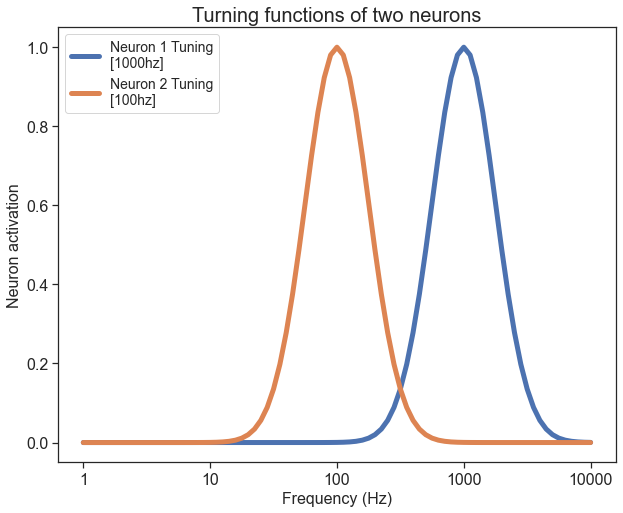

In [624]:
neuron1_x, neuron1_y = Gaussian_func(neuron_1_tun_pref, neuron_1_tun_shrp, tuning_lim, tuning_stepsize)
neuron2_x, neuron2_y = Gaussian_func(neuron_2_tun_pref, neuron_2_tun_shrp, tuning_lim, tuning_stepsize)

figsize(10, 8)
sns.set_theme(style="ticks")

# create lineplots for both tuning functions
g = sns.lineplot(x=neuron1_x, 
                 y=neuron1_y, 
                 label='Neuron 1 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_1_tun_pref))),
                 lw=5)
g = sns.lineplot(x=neuron2_x, 
                 y=neuron2_y, 
                 label='Neuron 2 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_2_tun_pref))),
                 lw=5)
plt.xticks(neuron1_x[::round(len(neuron1_x)/tuning_lim[1])], 
           Exp_trans(neuron1_x)[::round(len(neuron1_x)/tuning_lim[1])].astype(int));

plt.title("Turning functions of two neurons", fontsize=20)
plt.ylabel("Neuron activation", fontsize=16)
plt.xlabel("Frequency (Hz)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="upper left", fontsize=14);

### Adaptation decays by stimulus history
Here we use the formula:
$f(n) = 1 - a_{fast} * exp^{(-\frac{n-1}{t_{fast}})} - a_{slow} * exp^{(-\frac{n-1}{t_{slow}})}$
Where:
+ $n$: is the number of trials back (stimulus history)
+ $a_{fast}$: magnitude of fast adaptation component
+ $t_{fast}$: recovery time of fast adaptation component
+ $a_{fast}$: magnitude of slow adaptation component
+ $t_{fast}$: recovery time of slow adaptation component

In [625]:
def Double_exp_decay_func(afast, tfast, aslow, tslow, xlims, stepsize):
    """input parameters of double exponential decay and returns and x and y array
    input:  afast: magnitude of fast adaptation
            tfast: recovery of fast adaptation
            aslow: magnitde of slow adaptation
            tslow: recovery of slow adaptation
    output: return np.array for x and y
    """
    # define x and y arrays
    return_x = np.arange(xlims[0], xlims[1]+stepsize, stepsize)
    return_y = np.zeros(return_x.shape[0])
    
    # get y value for each step x
    for x in range(return_x.shape[0]):
        return_y[x] = 1 - (afast * np.exp(-(return_x[x]-1)/tfast)) - (aslow * np.exp(-(return_x[x]-1)/tslow))
    
    return(return_x, return_y) # return x and y array

In [626]:
# set parameters for double exp decay
afast = 0.1399 
tfast = 0.85
aslow = 0.0345
tslow = 6.82

# set bounds and stepsize
decay_bounds = [1,30]
decay_stepsize = 1   # because we are interested in stimuli, keep this on 1

# get decay arrays
x_decay, y_decay = Double_exp_decay_func(afast, tfast, aslow, tslow, decay_bounds, decay_stepsize)

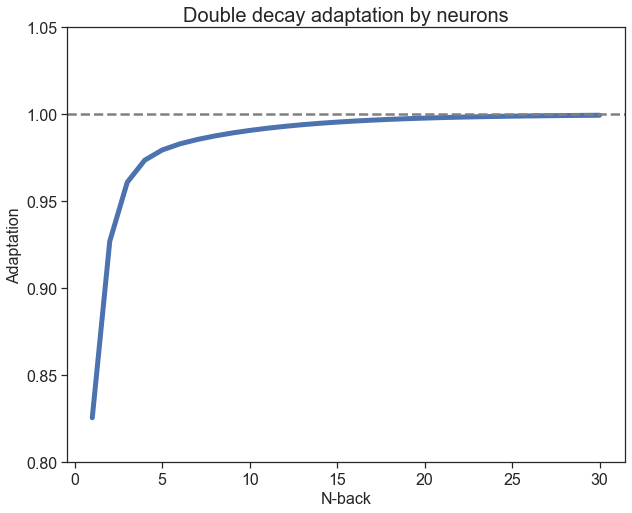

In [627]:
figsize(10, 8)
sns.set_theme(style="ticks")

# create lineplots for both tuning functions
g = sns.lineplot(x=x_decay, 
                 y=y_decay, 
                 lw=5)

plt.title("Double decay adaptation by neurons", fontsize=20)
plt.ylabel("Adaptation", fontsize=16)
plt.xlabel("N-back", fontsize=16)
plt.axhline(1, color='grey', lw=2.5, ls='--')
plt.ylim([0.80, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

In [628]:
y_decay

array([0.8256    , 0.92706498, 0.96096584, 0.97367597, 0.97954389,
       0.98303616, 0.98556635, 0.98760166, 0.9893132 , 0.99077706,
       0.99203689, 0.99312353, 0.99406156, 0.99487153, 0.99557099,
       0.99617505, 0.99669671, 0.99714723, 0.9975363 , 0.99787231,
       0.9981625 , 0.9984131 , 0.99862953, 0.99881644, 0.99897786,
       0.99911726, 0.99923766, 0.99934163, 0.99943142, 0.99950897])

In [629]:
n-3
n-2
n-1   
n    : A

NameError: name 'n' is not defined

## Off to the the races 🐎 - loop over the stimulus set
For now we take only 6 N-backs, to keep things simple

In [630]:
def Stim_adaptation(stim_train, y_decay):
    """Input a stimulus train of some length and n-back decay array,
    then return per stimulus adaptation (multiplicative and full array)
    input: stim_train: the n long stim train
           y_decay: n-back array from decay function
    returns: total_adapt: multiplicative adaptation per stim [length stim train]
             adapt_matrix: complete adaptation matrix [length stim train  *  number of N-backs]"""

    adapt_matrix = np.zeros([len(stim_train), len(y_decay)])   # make empty matrix of train length by number of N-backs 
    total_adapt = np.zeros(len(stim_train))                    # make empty array of stim train length

    # loop over stimuli starting at N+1
    for stim in range(0, len(stim_train)):

        # create a temp nback array to indicate adoptation
        n_back_array = np.zeros(len(y_decay))

        # for the first few stimulus (to avoid wrapping)
        if stim <= len(y_decay): 
            # populate Nback array with boolean, starting from right most (n-1)
            
            n_back_array[:stim] = (stim_train[:stim] == stim_train[stim]).astype(int)[::-1]

            print(n_back_array)
            
        else: 
            # populate Nback array with boolean, starting from right most (n-1)
            n_back_array[:] = (stim_train[stim-len(y_decay):stim] == stim_train[stim]).astype(int)[::-1]

        # populate our return arrays
        n_back_array *= y_decay                                      # multiply boolean array by decay array (1 encoding) 
        adapt_matrix[stim,:] = n_back_array                          # full length by N-backs array
        total_adapt[stim] = np.prod(n_back_array[n_back_array > 0])  # multiplicative adaptation
        
#         print(n_back_array)
#         print(1-(1-n_back_array[n_back_array > 0]).sum())
#         print('-----------------')
#         total_adapt[stim] = 1-(1-n_back_array[n_back_array > 0]).sum()
        
        
        
#         if n_back_array.sum() > 0: total_adapt[stim] = np.prod(n_back_array[n_back_array > 0])  # multiplicative adaptation
#         else: total_adapt[stim]: 0.0

    return(total_adapt, adapt_matrix)

In [631]:
def Stim_adaptation(stim_train, y_decay, 
                    tun_pref, tun_sharp, tun_peak=1):
    """Input a stimulus train of some length and n-back decay array,
    then return per stimulus adaptation (multiplicative and full array)
    input: stim_train: the n long stim train
           y_decay: n-back array from decay function
    returns: total_adapt: multiplicative adaptation per stim [length stim train]
             adapt_matrix: complete adaptation matrix [length stim train  *  number of N-backs]"""

    adapt_matrix = np.zeros([len(stim_train), len(y_decay)])   # make empty matrix of train length by number of N-backs 
    total_adapt = np.zeros(len(stim_train))                    # make empty array of stim train length
    activations = gaussian_activations(tun_pref, tun_sharp, stim_train, tun_peak=tun_peak)
    
    # loop over stimuli starting at N+1
    for stim in range(0, len(stim_train)):

        # create a temp nback array to indicate adoptation
        n_back_array = np.zeros(len(y_decay))

        # for the first few stimulus (to avoid wrapping)
        if stim <= len(y_decay): 
            # populate Nback array with boolean, starting from right most (n-1)
            n_back_array[:stim] = activations[:stim][::-1]

        else: 
            # populate Nback array with boolean, starting from right most (n-1)
            n_back_array[:] = activations[stim-len(y_decay):stim][::-1]
            
            # TOT HIER GEBLEVEN

        # populate our return arrays
        n_back_array *= y_decay                                      # multiply boolean array by decay array (1 encoding) 
        
        print(n_back_array)
        
        adapt_matrix[stim,:] = n_back_array                          # full length by N-backs array
        total_adapt[stim] = np.prod(n_back_array, where = n_back_array > 0)  # multiplicative adaptation
        
#         print(n_back_array)
#         print(1-(1-n_back_array[n_back_array > 0]).sum())
#         print('-----------------')
#         total_adapt[stim] = 1-(1-n_back_array[n_back_array > 0]).sum()
        
        
        
#         if n_back_array.sum() > 0: total_adapt[stim] = np.prod(n_back_array[n_back_array > 0])  # multiplicative adaptation
#         else: total_adapt[stim]: 0.0

    return(total_adapt, adapt_matrix)

In [632]:

abc = np.array([1, 3, 0, 2])
np.prod(np.array([1, 3, 0, 2]), where = abc > 0)

6

In [633]:
n_back_array

NameError: name 'n_back_array' is not defined

In [637]:
def gaussian_activations(tun_pref, tun_sharp, x_array, tun_peak=1):
    """Get y / hight on gaussian for a certain x array
    input: tun_pref=tuning prefference
           tun_sharp=tuning sharpness
           x=x array to calculate
    return: y value for that x"""
    return(tun_peak * np.exp(-((x_array-tun_pref)**2)/(2*tun_sharp**2)))

In [638]:
# function to get activations
activations = gaussian_activations(2.8, 1, stim_train)

stim = 5

# get previous activations
activations[stim-len(y_decay):stim][::-1]


# activations[::-1]

array([], dtype=float64)

In [640]:
activations

array([0.98019867, 0.72614904, 0.98019867, 0.98019867, 0.72614904,
       0.98019867, 0.98019867, 0.98019867, 0.98019867, 0.72614904,
       0.98019867, 0.72614904, 0.72614904, 0.98019867, 0.72614904,
       0.72614904, 0.98019867, 0.72614904, 0.98019867, 0.72614904,
       0.72614904, 0.72614904, 0.72614904, 0.98019867, 0.98019867,
       0.98019867, 0.98019867, 0.72614904, 0.98019867, 0.72614904,
       0.72614904, 0.72614904, 0.98019867, 0.98019867, 0.98019867,
       0.72614904, 0.98019867, 0.72614904, 0.98019867, 0.72614904,
       0.98019867, 0.72614904, 0.98019867, 0.98019867, 0.98019867,
       0.98019867, 0.98019867, 0.72614904, 0.72614904, 0.98019867,
       0.98019867, 0.72614904, 0.98019867, 0.72614904, 0.72614904,
       0.72614904, 0.72614904, 0.98019867, 0.72614904, 0.72614904,
       0.72614904, 0.72614904, 0.72614904, 0.72614904, 0.72614904,
       0.98019867, 0.72614904, 0.72614904, 0.72614904, 0.72614904,
       0.72614904, 0.72614904, 0.72614904, 0.72614904, 0.72614

In [606]:
## HIERBOVEN IS EEN BINARY VARIANT
## MAAK NIEUWE MET STIM_ADAPTATION


# NEEDS
# Y_DECAY 
# Y_ACTIVATIONS

# SO HERE WE HAVE A BOOLEAN, BUT INSTEAD WE HAVE TO USE ACTIVATION


# begin is er maar werkt nog niet helemaal
# de functie moet alle vorige adapties met elkaar vermenigvuldigen


In [617]:
stim_train = np.array([3] * 50)
stim_train[1] = 0 
stim_train[2] = 2
stim_train[3] = 2.8
stim_train[4] = 1
stim_train[5] = 0 
stim_train[6] = 5
stim_train[7] = 1
stim_train[8] = 1.5

In [618]:
adapt_total, adapt_matrix = Stim_adaptation(stim_train, y_decay, 2.8, 1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0.80925202 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.01638081 0.90870786 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.59950865 0.01839398 0.94193744 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.     

<IPython.core.display.Javascript object>


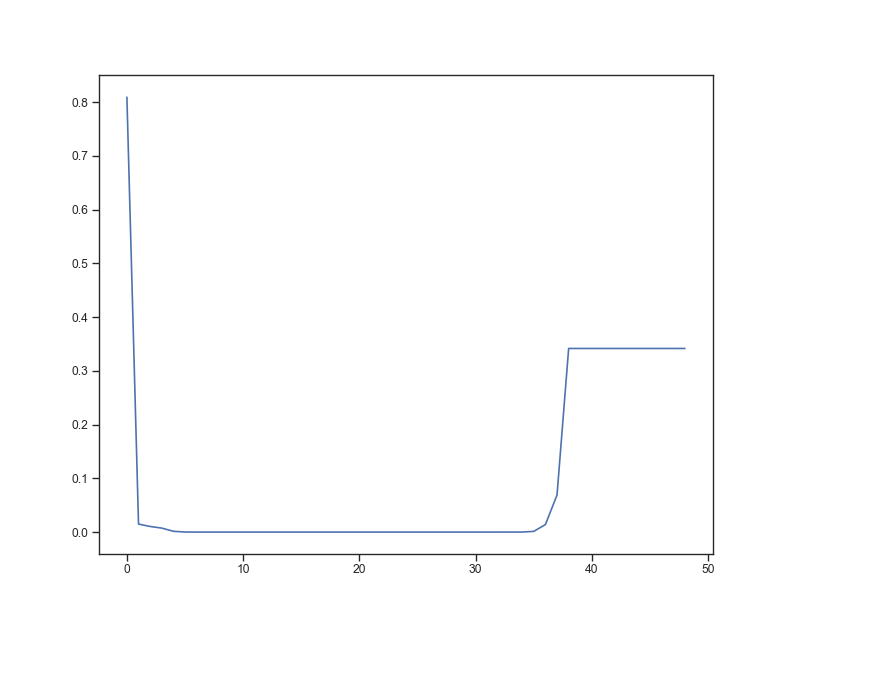

In [619]:
plt.plot(adapt_total[1:])

<IPython.core.display.Javascript object>


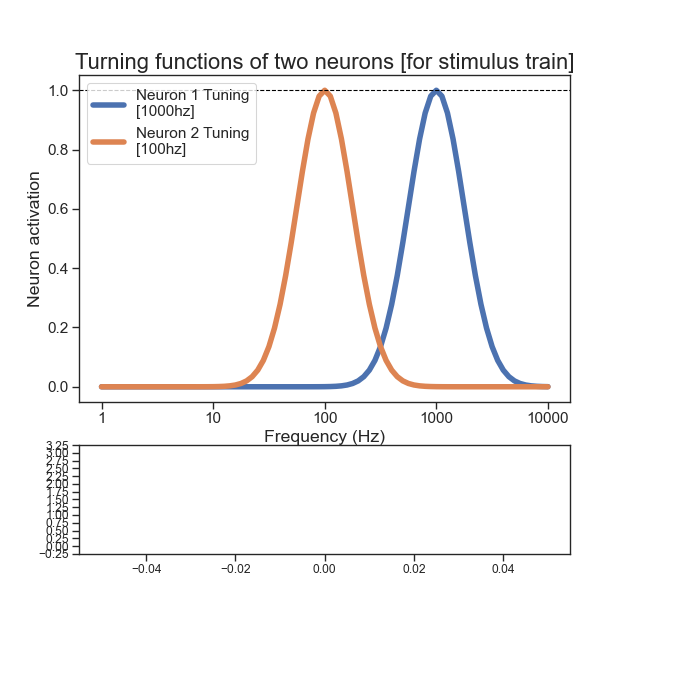

In [562]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# get base tuning curve
neuron1_x, neuron1_y = Gaussian_func(neuron_1_tun_pref, neuron_1_tun_shrp, tuning_lim, tuning_stepsize)
neuron2_x, neuron2_y = Gaussian_func(neuron_2_tun_pref, neuron_2_tun_shrp, tuning_lim, tuning_stepsize)

# set when new activation happens
adapt_total_n1 = (stim_train == neuron_1_tun_pref).astype(int) * adapt_total
adapt_total_n2 = (stim_train == neuron_2_tun_pref).astype(int) * adapt_total

# constants and x array
length = len(stim_train)

# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

# creating our line objects for the plots
n1, = ax1.plot(neuron1_x, neuron1_y, 
               label='Neuron 1 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_1_tun_pref))),
               lw=5)
n2, = ax1.plot(neuron2_x, neuron2_y, 
               label='Neuron 2 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_2_tun_pref))),
               lw=5)

# stimuli presentation plot
stim, = ax2.plot(stim_train[0])

def animate(B):
    """
    this function gets called by FuncAnimation
    each time called, it will replot with a different tuning peak "B"
    """
    
    # create our neuron 1 tuning func
    n1.set_ydata(Gaussian_func(neuron_1_tun_pref, 
                               neuron_1_tun_shrp, 
                               tuning_lim, 
                               tuning_stepsize, 
                               tun_peak=adapt_total_n1[B])[1])
    
    # create our neuron 2 tuning func
    n2.set_ydata(Gaussian_func(neuron_2_tun_pref, 
                               neuron_2_tun_shrp, 
                               tuning_lim, 
                               tuning_stepsize, 
                               tun_peak=adapt_total_n2[B])[1])
    
    # and for stimulus presentation
    if B < 40:
        stim.set_xdata(steps[0:B])
        stim.set_ydata(stim_train[0:B])
        ax2.set_xlim(0, B)
    else:
        stim.set_xdata(steps[B-40:B])
        stim.set_ydata(stim_train[B-40:B])    
        ax2.set_xlim(B-40, B)

    
    
def init():
    """
    initialize the figure
    """
    # set horizontal line for 'default' activation
    ax1.axhline(1, color='black', lw=1, ls='--')
    
    # set xtick dimension
    ax1.set_xticks(neuron1_x[::round(len(neuron1_x)/tuning_lim[1])])
    ax1.set_xticklabels(Exp_trans(neuron1_x)[::round(len(neuron1_x)/tuning_lim[1])].astype(int), fontsize=14)
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=14)
    
    # set text
    ax1.legend(loc="upper left", fontsize=14);
    ax1.set_title("Turning functions of two neurons [for stimulus train]", fontsize=20)
    ax1.set_ylabel("Neuron activation", fontsize=16)
    ax1.set_xlabel("Frequency (Hz)", fontsize=16)
    
    # set y ticks for 2nd graph
    ax2.set_yticks(np.arange(stim_train.min()-0.25, stim_train.max()+0.5, 0.25))
    ax2.set_yticklabels(['','100Hz','','','','1000Hz',''], fontsize=14)
    
    return n1, n2, stim

steps = np.arange(0, len(stim_train[:200]))
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=50, blit=False)
plt.show()


# Writer = FFMpegWriter
# writer = Writer(fps=5, metadata={'artist': 'Me'}, bitrate=1800)

# ani.save('animations/neuron_activation.mp4', writer)


### Lets look at a toy sequences that are less random [3X100hz, 3x1000hz repeating]

In [15]:
# make new sequence
stim_train_2 = np.tile(([2] * 4) + ([3] * 4), 125)

# get base tuning curve
neuron1_x, neuron1_y = Gaussian_func(neuron_1_tun_pref, neuron_1_tun_shrp, tuning_lim, tuning_stepsize)
neuron2_x, neuron2_y = Gaussian_func(neuron_2_tun_pref, neuron_2_tun_shrp, tuning_lim, tuning_stepsize)

# set when new activation happens
adapt_total_n1 = (stim_train_2 == neuron_1_tun_pref).astype(int) * adapt_total
adapt_total_n2 = (stim_train_2 == neuron_2_tun_pref).astype(int) * adapt_total

# constants and x array
length = len(stim_train_2)

# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

# creating our line objects for the plots
n1, = ax1.plot(neuron1_x, neuron1_y, 
               label='Neuron 1 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_1_tun_pref))),
               lw=5)
n2, = ax1.plot(neuron2_x, neuron2_y, 
               label='Neuron 2 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_2_tun_pref))),
               lw=5)

def animate(B):
    """
    this function gets called by FuncAnimation
    each time called, it will replot with a different tuning peak "B"
    """
    
    # create our neuron 1 tuning func
    n1.set_ydata(Gaussian_func(neuron_1_tun_pref, 
                               neuron_1_tun_shrp, 
                               tuning_lim, 
                               tuning_stepsize, 
                               tun_peak=adapt_total_n1[B])[1])
    
    # create our neuron 2 tuning func
    n2.set_ydata(Gaussian_func(neuron_2_tun_pref, 
                               neuron_2_tun_shrp, 
                               tuning_lim, 
                               tuning_stepsize, 
                               tun_peak=adapt_total_n2[B])[1])
    
    # and for stimulus presentation
    if B < 40:
        stim.set_xdata(steps[0:B])
        stim.set_ydata(stim_train_2[0:B])
        ax2.set_xlim(0, B)
    else:
        stim.set_xdata(steps[B-40:B])
        stim.set_ydata(stim_train_2[B-40:B])    
        ax2.set_xlim(B-40, B)

# stimuli presentation plot
stim, = ax2.plot(stim_train_2[0])


steps = np.arange(0, len(stim_train_2[:200]))
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=200, blit=False)
plt.show()


# Writer = FFMpegWriter
# writer = Writer(fps=5, metadata={'artist': 'Me'}, bitrate=1800)

# ani.save('animations/neuron_activation_longsequences.mp4', writer)

ValueError: operands could not be broadcast together with shapes (1000,) (30,) 

In [563]:
neuron1_x, neuron1_y = Gaussian_func(neuron_1_tun_pref, neuron_1_tun_shrp, tuning_lim, tuning_stepsize)

y = neuron1_x[30:]           # the size of our tuning function
x = np.arange(1, 30)   # our temporal component

X, Y = np.meshgrid(x,y)

adapt_total, adapt_matrix = Stim_adaptation(stim_train, y_decay)
adapt_total_n1 = (stim_train == neuron_1_tun_pref).astype(int) * adapt_total

Z = np.zeros(X.shape)

for i in range(len(Z[0,:])):
    x, y = Gaussian_func(neuron_1_tun_pref, neuron_1_tun_shrp, tuning_lim, tuning_stepsize, tun_peak=adapt_total_n1[i])
    Z[:,i] = y[30:]
    
figsize(12, 12)
    
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Activation over time', fontsize=20)
ax.set_xlabel("Temporal stimulus presentation", fontsize=16)
ax.set_ylabel("Frequency tuning (log transformed)", fontsize=16)
ax.set_ylabel("Frequency tuning (log transformed)", fontsize=16)
ax.set_zlabel("Relative activation", fontsize=16);

TypeError: Stim_adaptation() missing 2 required positional arguments: 'tun_pref' and 'tun_sharp'

## However...
Modelling adaptation statically by using N-x trails and using this multiplicative result for next stimulation seems inefficient (and not tractible if we consider N-all past events).
+ We can get to the same results if we model the adaptation itself as a decaying function
+ Where the decay is only dependent on the residual decay and the last activation

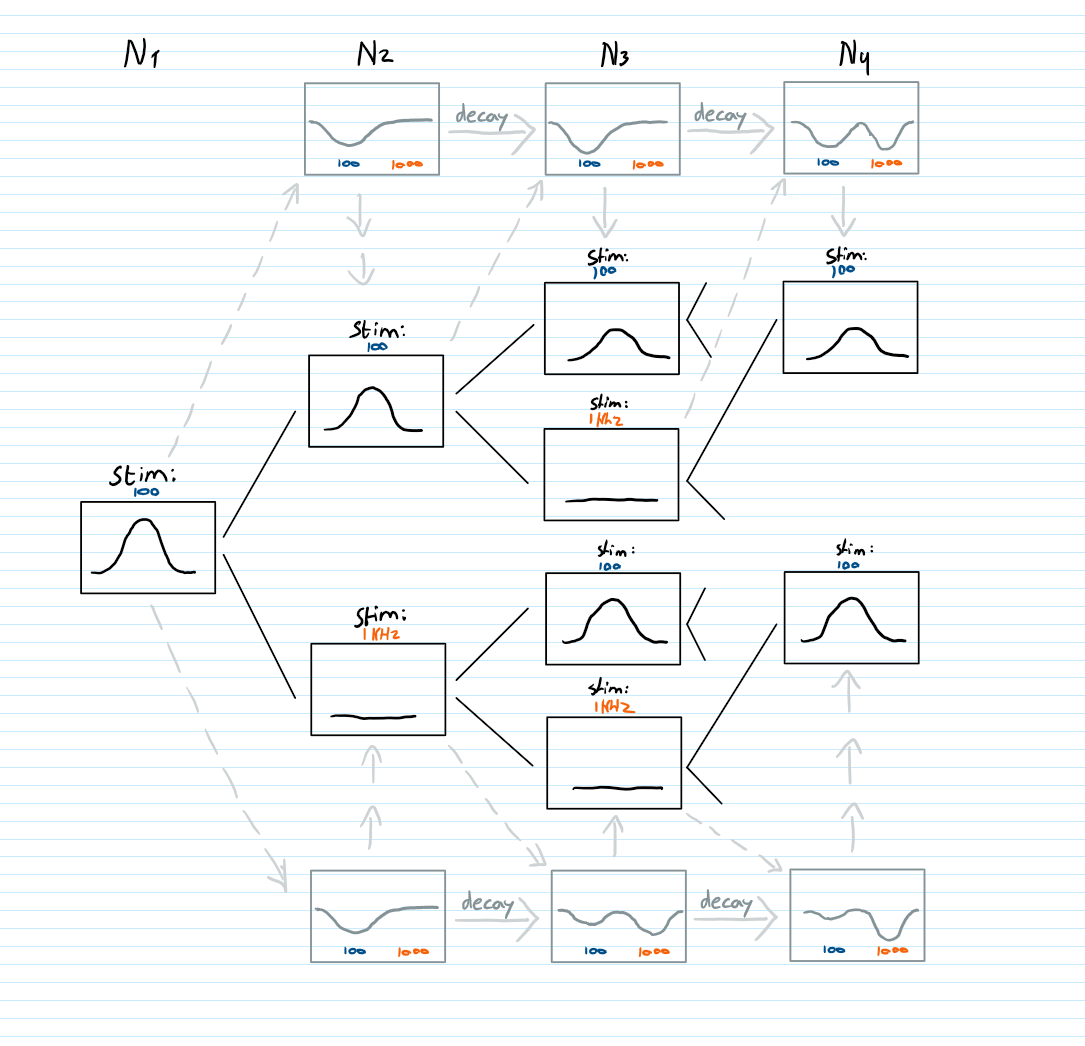

Note: that we can do this because we assume that adaptation is dependent on previous activation.
+ presenting an adoptation function landscape
+ however, if adaptation works by a threshold (only adoptation at x> activation) - then this landscape will behave differently

In [420]:
# set parameters for double exp decay
afast = 0.1399 
tfast = 0.85
aslow = 0.0345
tslow = 6.82

# pre create our arrays
n_1_adaptation = np.empty(2)
res_adaptation = np.zeros(2)
adaptation = np.zeros(2)
a = [afast, aslow]
t = [tfast, tslow]

In [421]:
activations = [1, 1, 1, 0, 1]
adaptation_per_stim = np.zeros(len(activations))

for activation in range(len(activations)):

    # loop over the kinds of adaptation (in this case just fast and slow but can be expended)
    # ([0] = fast, [1] = slow)
    for i in range(len(n_1_adaptation)):

        # set new adaptation and decay residual adaptation
        n_1_adaptation[i] = activations[activation] * a[i]
        res_adaptation[i] = adaptation[i] * np.exp(-(1/t[i]))

        # add new to decayed residual adaptation
        adaptation[i] = n_1_adaptation[i] + res_adaptation[i] 

#### You can see that the residual adaptation by this step function (ABB) is identical to the one calculated by the double exp decay function

In [422]:
print("Exponential decay function: {0:.3g}\nStep function: {0:.3g}".format(y_decay[2], 1-adaptation.sum()))

Exponential decay function: 0.961
Step function: 0.961


#### Wrap it in a function

In [423]:
def Decay_step(prev_activation, a, t, res_adaptation, exp_explosion=False): #0.99):
    """Take two components, previous residual decay and previous activity
    input: prev_activation: n-1 activation
           a: array of [afast, aslow]
           t: array of [tfast, tslow]
           res_adaptation: residual adaptation leftover,
    optional in: exp_eplosion: default 0.99 - to make sure that for 
                 long stim trains adaptation does not goes to infitity
    output: return current trial adaptation"""
    
    # Small check to reset res decay if it goes above 98,5% 
    # This is not necesarry but, for long chains (in the limit) any kind of prev_activation would be impossible
    if exp_explosion != False:
        if (1-res_adaptation.sum()) > exp_explosion: res_adaptation = np.zeros(2)
    
    # set empty array for N-1 adaptation
    n_1_adaptation = np.zeros(len(a))
    adaptation = np.zeros(len(a))
    
    # loop over the kinds of adaptation (in this case just fast and slow but can be expended)
    # ([0] = fast, [1] = slow)
    for i in range(len(a)):

        # set new adaptation and decay residual adaptation
        n_1_adaptation[i] = prev_activation * a[i]                   # calculate n-1 adaptation
        res_adaptation[i] = res_adaptation[i] * np.exp(-(1/t[i]))   # decay prev residual
        
        # add new to decayed residual adaptation
        adaptation[i] = n_1_adaptation[i] + res_adaptation[i]       # add current n-1 decay
    
    return(adaptation,  (1-n_1_adaptation.sum()) * (1-res_adaptation.sum()))


def Calc_activation(activation, adaptation):
    return((1-adaptation) * activation)

In [424]:
residual_adapt, adaptation = Decay_step(1, 
             [afast, aslow], 
             [tfast, tslow], 
             np.array([0, 0]))

print(1, residual_adapt, adaptation)
print('--------------------')

residual_adapt, adaptation = Decay_step(1, 
             [afast, aslow], 
             [tfast, tslow], 
             residual_adapt)

print(2, residual_adapt, adaptation)
print('--------------------')

1 [0.1399 0.0345] 0.8256
--------------------
2 [0.18304029 0.06429474] 0.7653848444192585
--------------------


### For now, we still use our two neurons, that are tuned exactly on the stimuli
This means we dont need to calculate the gaussian point hight for the input stimuli, since in this toy example where the stim are based on the tuning.

In [425]:
neuron1_bool = (stim_train == neuron_1_tun_pref).astype(int)
neuron2_bool = (stim_train == neuron_2_tun_pref).astype(int)

# crete adaptation for neurons
adaptation_neuron1 = np.ones([len(stim_train)])
adaptation_neuron2 = np.ones([len(stim_train)])
prev_adaptation_n1 = np.array([0, 0])
prev_adaptation_n2 = np.array([0, 0])

for i in range(0, len(stim_train)):
    
    # check new adaptation
    if i > 0:
        prev_adaptation_n1, adaptation_neuron1[i], = Decay_step(neuron1_bool[i-1], 
                                                                 [afast, aslow], 
                                                                 [tfast, tslow], 
                                                                 prev_adaptation_n1)
        prev_adaptation_n2, adaptation_neuron2[i] = Decay_step(neuron2_bool[i-1], 
                                                                 [afast, aslow], 
                                                                 [tfast, tslow], 
                                                                 prev_adaptation_n2)

### Plot results for neuron 1
+ As you may notice: results are identical to the top of the 3d plot before

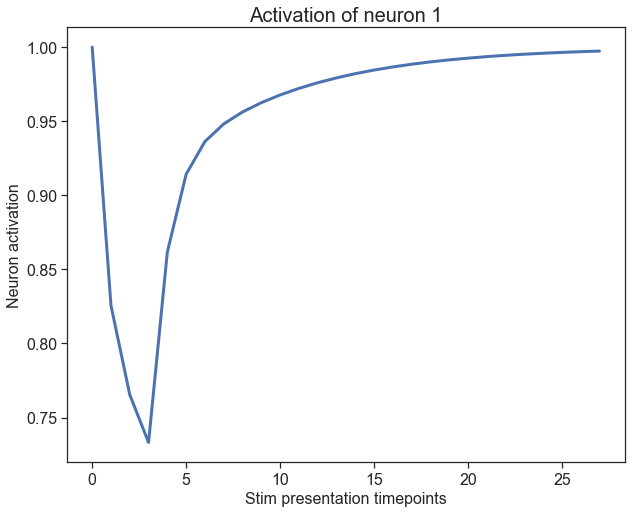

In [378]:
%matplotlib inline

x = np.arange(1, 30)
y_1 = adaptation_neuron2

figsize(10, 8)
plt.plot(adaptation_neuron2[1:len(x)], label="Neuron 1", lw=3)
# plt.plot(activation_neuron2[:len(x)], label="Neuron 2")

plt.title("Activation of neuron 1", fontsize=20)
plt.ylabel("Neuron activation", fontsize=16)
plt.xlabel("Stim presentation timepoints", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);
# plt.legend(loc="upper left", fontsize=14);

# Lets move away from 'perfectly tuned' stimuli
next we look at what happens when we present the model with uniformly distributed stimuli 
activation is determined by:
1. where the stimuli is on the tuning curve
2. adaptation caused by all previous activations

In [379]:
random_stim_train = np.random.uniform(1,4,len(stim_train))  # create new stim train (uniform random between log1-4hz)

In [399]:
# crete adaptation for neurons
adaptation_neuron1 = np.ones([len(stim_train)])
adaptation_neuron2 = np.ones([len(stim_train)])
prev_adaptation_n1 = np.array([0, 0])
prev_adaptation_n2 = np.array([0, 0])

stim_activation_n1 = np.zeros(len(random_stim_train))
stim_activation_n2 = np.zeros(len(random_stim_train))
stim_activation_n1[0] = Gaussian_point(neuron_1_tun_pref, neuron_1_tun_shrp, random_stim_train[0])
stim_activation_n2[0] = Gaussian_point(neuron_2_tun_pref, neuron_2_tun_shrp, random_stim_train[0])

for i in range(1, len(stim_train)):
    
    # check new adaptation
    prev_adaptation_n1, adaptation_neuron1[i] = Decay_step(stim_activation_n1[i-1], 
                                         [afast, aslow], 
                                         [tfast, tslow], 
                                         prev_adaptation_n1)
    prev_adaptation_n2, adaptation_neuron2[i] = Decay_step(stim_activation_n2[i-1], 
                                         [afast, aslow], 
                                         [tfast, tslow], 
                                         prev_adaptation_n2)

    # and calculate activation    
    stim_activation_n1[i] = Gaussian_point(neuron_1_tun_pref, neuron_1_tun_shrp, random_stim_train[i])
    stim_activation_n2[i] = Gaussian_point(neuron_2_tun_pref, neuron_2_tun_shrp, random_stim_train[i])

stim_activation_n1_adapted = stim_activation_n1 * adaptation_neuron1
stim_activation_n2_adapted = stim_activation_n2 * adaptation_neuron2

Text(0.5, 0, 'Stimuli presented')

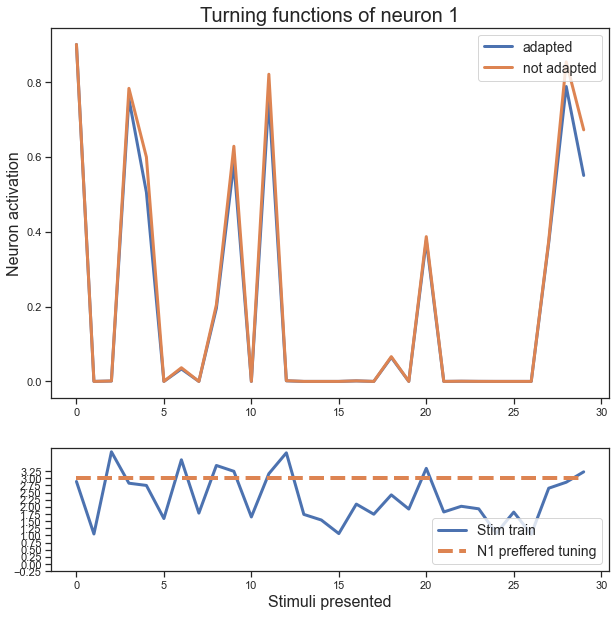

In [404]:
# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(stim_activation_n1_adapted[:30], lw=3, label='adapted')
ax1.plot(stim_activation_n1[:30], lw=3, label='not adapted')
ax1.legend(fontsize=14)

ax2.plot(random_stim_train[:30], lw=3, label='Stim train')
ax2.plot([neuron_1_tun_pref] * 30, lw=4, ls='--', label='N1 preffered tuning')

# set text
ax2.legend(loc="lower right", fontsize=14);
ax1.set_title("Turning functions of neuron 1", fontsize=20)
ax1.set_ylabel("Neuron activation", fontsize=16)

# set y ticks for 2nd graph
ax2.set_yticks(np.arange(stim_train.min()-0.25, stim_train.max()+0.5, 0.25))
# ax2.set_yticklabels(['100Hz','','','','1000Hz',''], fontsize=14)
ax2.set_xlabel("Stimuli presented", fontsize=16)

Text(0.5, 0, 'Stimuli presented')

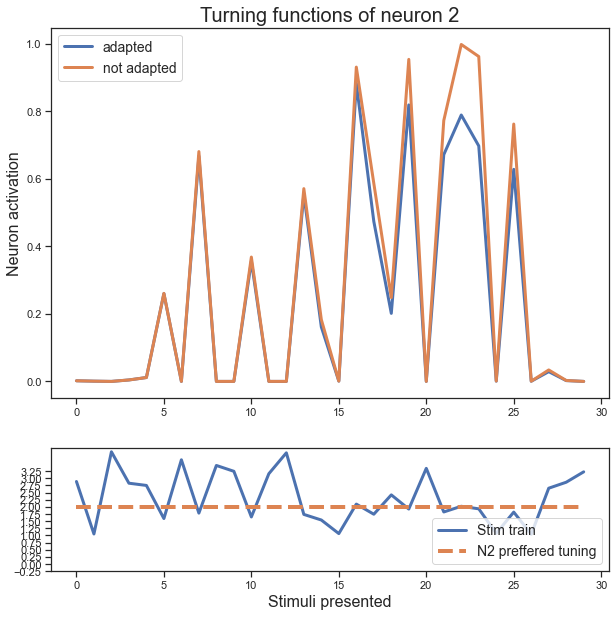

In [406]:
# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(stim_activation_n2_adapted[:30], lw=3, label='adapted')
ax1.plot(stim_activation_n2[:30], lw=3, label='not adapted')
ax1.legend(fontsize=14)

ax2.plot(random_stim_train[:30], lw=3, label='Stim train')
ax2.plot([neuron_2_tun_pref] * 30, lw=4, ls='--', label='N2 preffered tuning')

# set text
ax2.legend(loc="lower right", fontsize=14);
ax1.set_title("Turning functions of neuron 2", fontsize=20)
ax1.set_ylabel("Neuron activation", fontsize=16)

# set y ticks for 2nd graph
ax2.set_yticks(np.arange(stim_train.min()-0.25, stim_train.max()+0.5, 0.25))
# ax2.set_yticklabels(['100Hz','','','','1000Hz',''], fontsize=14)
ax2.set_xlabel("Stimuli presented", fontsize=16)

# Last, we want to move to many neurons, with many tuning functions
### what you see here are on population level

first we will make a dictonary with
+ a range (100) of neurons
+ these neurons all have some tuning prefference 
+ and some tuning sharpness/broadness

In [25]:
# create neuron tuning dict
neuron_tuning = {}
tuning_para = ['pref', 'shrp', 'peak']

# set ranges for our 1000 neurons
neurons = np.arange(1,101)
prefs = np.linspace(0.5,4.5,100)
shrps = np.linspace(0.05,1,20)

# loop over neurons
for nrn in range(len(neurons)):
    
    # create nested dict with neuron number
    neuron_tuning['neuron_{}'.format(neurons[nrn])] = {}
    
    # loop over sharpnesses
    for shr in range(len(shrps)):
        neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]  =  {}
        neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]['shrp'] = shrps[shr]
        neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]['pref'] = prefs[nrn]
        neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]['peak'] = 1

now we will store the stim train data in this dictonary

In [202]:
# loop over neurons
for nrn in range(len(neurons)):
    # loop over sharpnesses
    for shr in range(len(shrps)):

        # get tuning prefferences of neuron
        neuron_pref = neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]['pref']
        neuron_shrp = neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]['shrp']
        neuron_peak = neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]['peak']
        
        # crete adaptation for neurons
        adaptation_neuron = np.zeros([2, len(random_stim_train)])
        stim_activation = np.zeros(len(random_stim_train))
        stim_activation[0] = Gaussian_point(neuron_pref, neuron_shrp, random_stim_train[0])
        
        for stim in range(1, len(random_stim_train)):

            # check new adaptation
            adaptation_neuron[:,stim]= Decay_step(stim_activation[stim-1], 
                                                  [afast, aslow], 
                                                  [tfast, tslow], 
                                                  adaptation_neuron[:,stim-1])

            # and calculate activation
            trail_activation = Gaussian_point(neuron_pref, neuron_shrp, random_stim_train[stim])
            stim_activation[stim] = Calc_activation(trail_activation, adaptation_neuron[:,stim].sum())

            
        # substract from 1 to translate from relative adaptation to absolute
        adaptation_neuron = 1- adaptation_neuron.sum(axis=0)
        
        # save neuron data in dict
        neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]['adaptation'] = adaptation_neuron
        neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]['activation'] = stim_activation

In [26]:
# quickle save our nested dict
import pickle

pickle.dump(neuron_tuning, open('neurons.p', 'wb'))
# neuron_tuning = pickle.load(open('neurons.p', 'rb'))

### Lets plot these results in a heatmap (these are on population level)

In [27]:
trial = 207

# create timeseries [stimtrain * sharpness * neuronpref]
activation_timeseries = np.zeros([len(random_stim_train), len(shrps), len(neurons)])
adaptation_timeseries = np.zeros([len(random_stim_train), len(shrps), len(neurons)])

for nrn in range(len(neurons)):
    for shr in range(len(shrps)):
        activation_timeseries[:,shr,nrn] = neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]['activation']
        adaptation_timeseries[:,shr,nrn] = neuron_tuning['neuron_{}'.format(neurons[nrn])]['shrp_{}'.format(shrps[shr])]['adaptation']

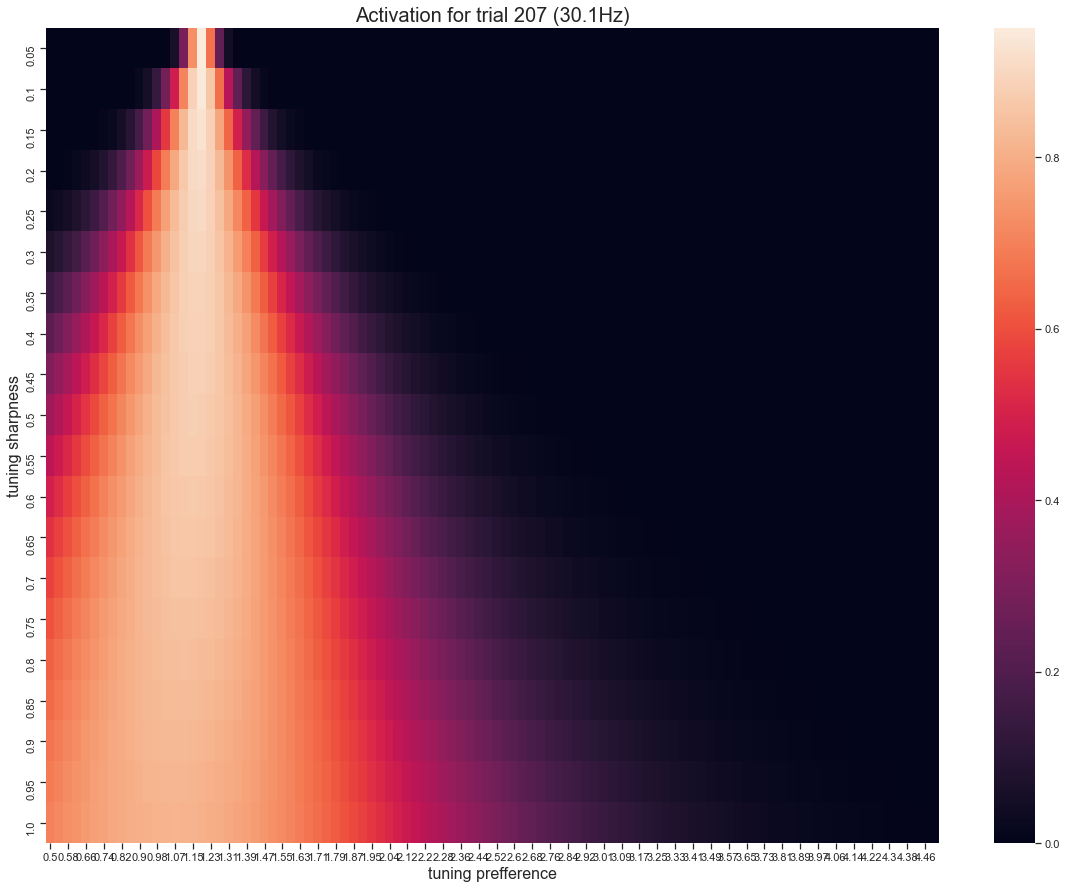

In [28]:
figsize(20, 15)

ax = sns.heatmap(activation_timeseries[trial,:,:])

# set text
ax.set_title("Activation for trial 207 ({0:.3g}Hz)".format(np.exp(random_stim_train[trial])), fontsize=20)
ax.set_ylabel("tuning sharpness", fontsize=16)
ax.set_xlabel("tuning prefference", fontsize=16)

ax.set_yticklabels(shrps[::1].round(2))
ax.set_xticklabels(prefs[::2].round(2));

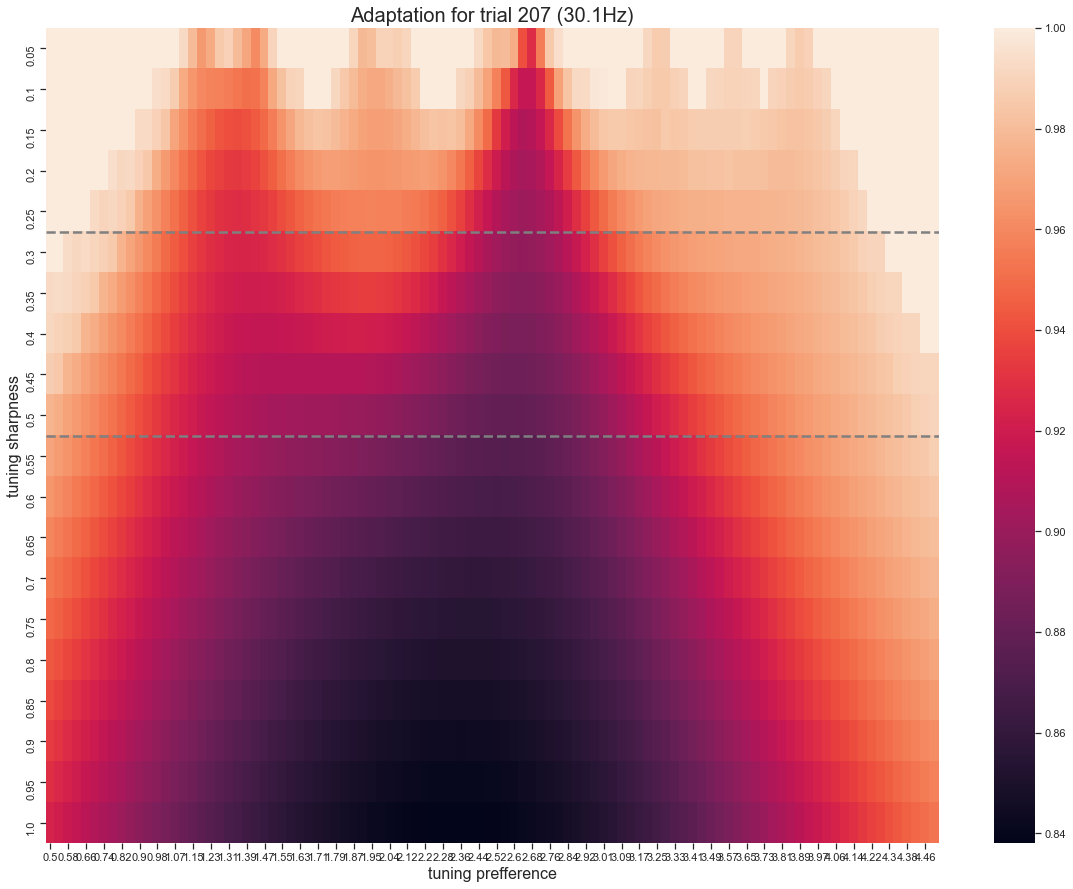

In [30]:
figsize(20, 15)

ax = sns.heatmap(adaptation_timeseries[trial,:,:])

# set text
ax.set_title("Adaptation for trial 207 ({0:.3g}Hz)".format(np.exp(random_stim_train[trial])), fontsize=20)
ax.set_ylabel("tuning sharpness", fontsize=16)
ax.set_xlabel("tuning prefference", fontsize=16)

plt.axhline(5, color='grey', lw=2.5, ls='--')
plt.axhline(10, color='grey', lw=2.5, ls='--')

ax.set_yticklabels(shrps[::1].round(2))
ax.set_xticklabels(prefs[::2].round(2));

<ipython-input-31-9df525303fdd>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_yticklabels(), fontsize=14)
<ipython-input-31-9df525303fdd>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax1.get_yticklabels(), fontsize=14);


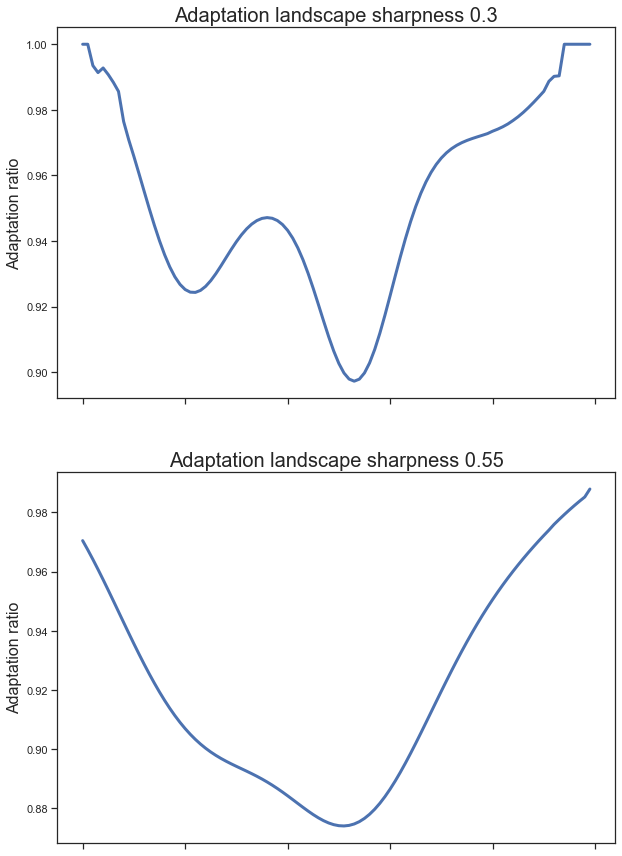

In [31]:
# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 15), gridspec_kw={'height_ratios': [1, 1]})

ax1.plot(adaptation_timeseries[trial,5,:], lw=3)
ax2.plot(adaptation_timeseries[trial,10,:], lw=3)

# set text
ax1.set_title("Adaptation landscape sharpness {0:.3g}".format(shrps[5]), fontsize=20)
ax2.set_title("Adaptation landscape sharpness {0:.3g}".format(shrps[10]), fontsize=20)
ax1.set_ylabel("Adaptation ratio", fontsize=16)
ax2.set_ylabel("Adaptation ratio", fontsize=16)

# ax1.set_xticks()
ax1.set_xticklabels(ax1.get_yticklabels(), fontsize=14)
ax2.set_xticklabels(ax1.get_yticklabels(), fontsize=14);

## lets show the timescourse of these

<IPython.core.display.Javascript object>


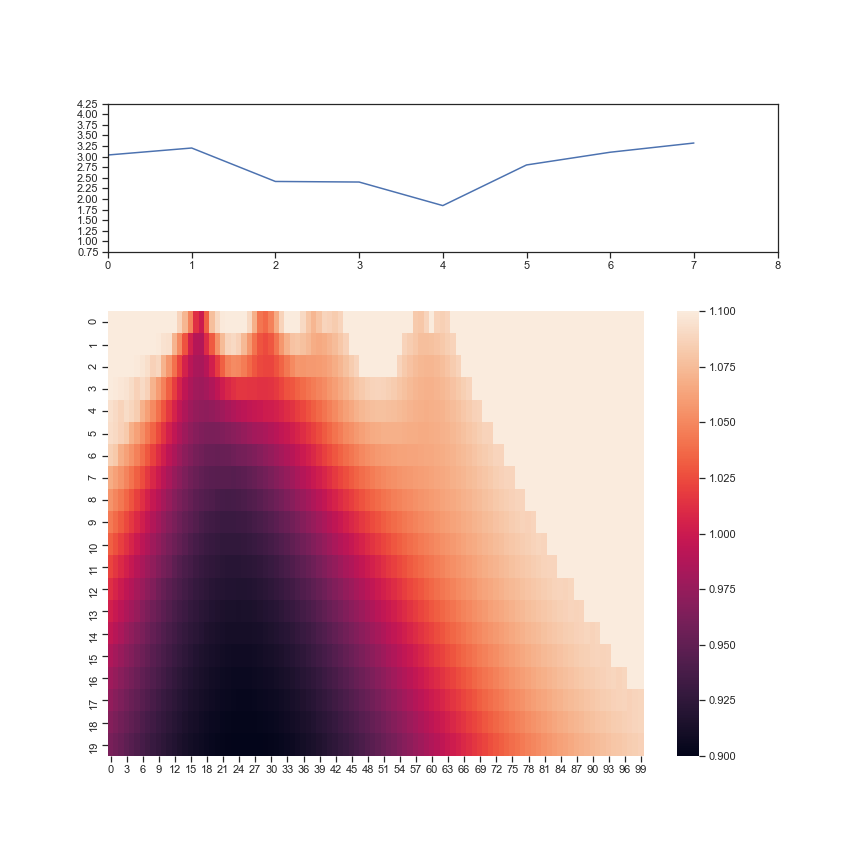

In [58]:
%matplotlib notebook
# %matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# get base tuning curve
start_data = adaptation_timeseries[0,:,:]

# constants and x array
length = len(random_stim_train)

# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 3]})

# stimuli presentation plot
stim, = ax1.plot(random_stim_train[0])

# creating our line objects for the plots
ax2 = sns.heatmap(start_data)

def animate(B):
    """
    this function gets called by FuncAnimation
    each time called, it will replot with a different tuning peak "B"
    """

    ax2 = sns.heatmap(adaptation_timeseries[B,:,:], cbar=False)
    
    # and for stimulus presentation
    if B < 40:
        stim.set_xdata(steps[0:B])
        stim.set_ydata(random_stim_train[0:B])
        ax1.set_xlim(0, B)
    else:
        stim.set_xdata(steps[B-40:B])
        stim.set_ydata(random_stim_train[B-40:B])    
        ax1.set_xlim(B-40, B)

    
    
def init():
    """
    initialize the figure
    """
    
    ax2 = sns.heatmap(start_data, cbar=False)
    
    # set y ticks for 2nd graph
    ax1.set_yticks(np.arange(random_stim_train.min()-0.25, random_stim_train.max()+0.5, 0.25))
    
    return stim,

steps = np.arange(0, len(stim_train))
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=50, blit=False)
plt.show()

# Writer = FFMpegWriter
# writer = Writer(fps=15, metadata={'artist': 'Me'}, bitrate=1800)

# ani.save('population_adapt.mp4', writer)


<IPython.core.display.Javascript object>


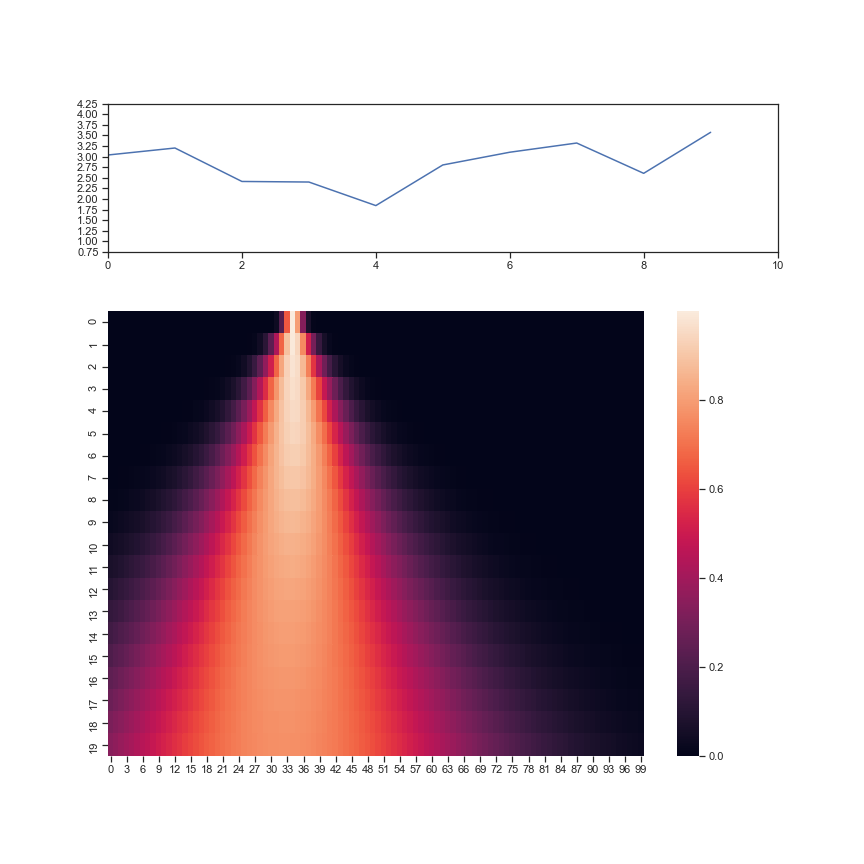

In [59]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# get base tuning curve
start_data = activation_timeseries[0,:,:]

# constants and x array
length = len(random_stim_train)

# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 3]})

# stimuli presentation plot
stim, = ax1.plot(random_stim_train[0])

# creating our line objects for the plots
ax2 = sns.heatmap(start_data)

def animate(B):
    """
    this function gets called by FuncAnimation
    each time called, it will replot with a different tuning peak "B"
    """

    ax2 = sns.heatmap(activation_timeseries[B,:,:], cbar=False)
    
    # and for stimulus presentation
    if B < 40:
        stim.set_xdata(steps[0:B])
        stim.set_ydata(random_stim_train[0:B])
        ax1.set_xlim(0, B)
    else:
        stim.set_xdata(steps[B-40:B])
        stim.set_ydata(random_stim_train[B-40:B])    
        ax1.set_xlim(B-40, B)

    
    
def init():
    """
    initialize the figure
    """
    
    ax2 = sns.heatmap(start_data, cbar=False)
    
    # set y ticks for 2nd graph
    ax1.set_yticks(np.arange(random_stim_train.min()-0.25, random_stim_train.max()+0.5, 0.25))
    
    return stim,

steps = np.arange(0, len(stim_train))
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=50, blit=False)
plt.show()

# Writer = FFMpegWriter
# writer = Writer(fps=15, metadata={'artist': 'Me'}, bitrate=1800)

# ani.save('population_activation.mp4', writer)


<IPython.core.display.Javascript object>


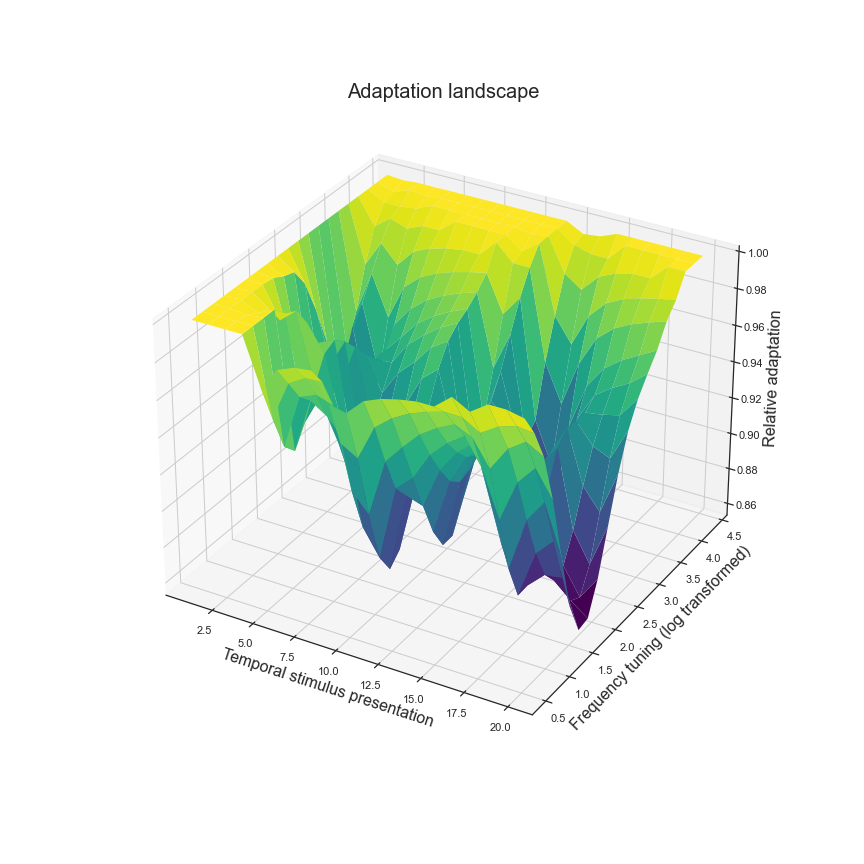

In [201]:
y = prefs[::5]                # the size of our tuning function
x = np.arange(1, 21)    # our temporal component


X, Y = np.meshgrid(x,y)
Z = adaptation_timeseries[:20,7,::5].T

    
figsize(12, 12)
    
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Adaptation landscape', fontsize=20)
ax.set_xlabel("Temporal stimulus presentation", fontsize=16)
ax.set_ylabel("Frequency tuning (log transformed)", fontsize=16)
ax.set_ylabel("Frequency tuning (log transformed)", fontsize=16)
ax.set_zlabel("Relative adaptation", fontsize=16);

In [ ]:
# F. OTHER KINDS OF ADAPTATION, SHAPENING/BROADENING OR SHIFTING

# LONG TEMP PLANS:
# 1. ADD NOISE TO THE GAUSSIAN FUNCTIONS
# 1b. THIS NOISE SHOULD BE ACTIVATION DEPENDENT (HIGHER ACTIVATION, MORE VARIABLITY)
# 1c. THEN THE PLOTS CAN HAVE A 95CI (BOOTSTRAPPED)
# 2. WRAP FUNCTIONS IN .PY FILE AND LOAD FROM THERE